In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

In [4]:
# Time axis
timesteps = 500
x = np.arange(timesteps)

# Base signal: smooth sine wave with small noise
normal_signal = np.sin(0.02 * x) + 0.05 * np.random.randn(timesteps)

# Start with all normal
data = normal_signal.copy()
anomaly_indices = np.random.choice(timesteps, size=10, replace=False)

# Inject small anomalies (less than ±0.5 deviation)
for idx in anomaly_indices:
    data[idx] += np.random.uniform(-0.4, 0.4)

# Save labels for evaluation
labels = np.zeros(timesteps)
labels[anomaly_indices] = 1

df = pd.DataFrame({
    'value': data,
    'anomaly': labels.astype(int)
})

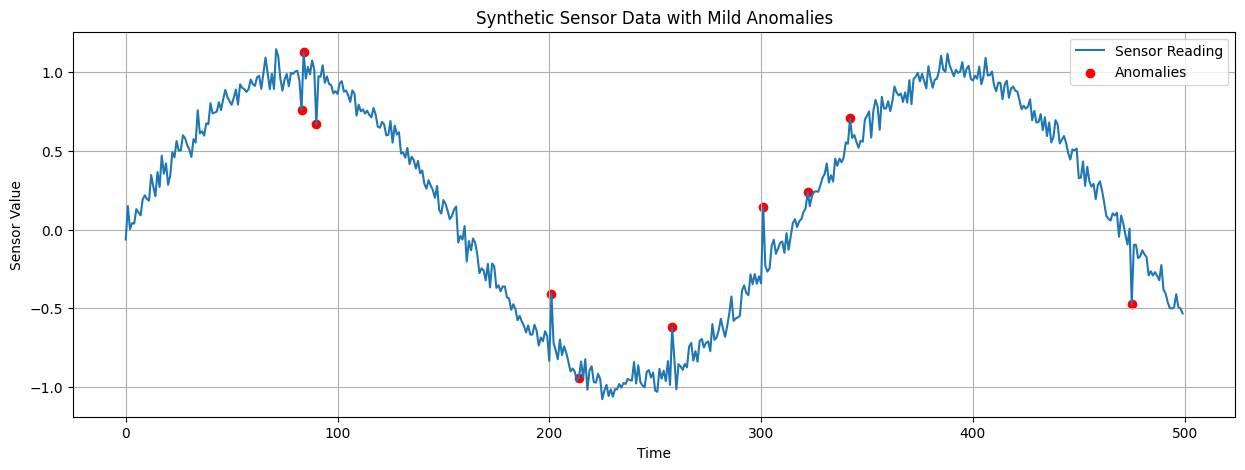

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(data, label='Sensor Reading')
plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label='Anomalies')
plt.title("Synthetic Sensor Data with Mild Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
df[df['anomaly'] == 1]

,value,anomaly
83,0.761480,1
84,1.127355,1
90,0.670840,1
201,-0.406800,1
214,-0.940419,1
258,-0.621305,1
301,0.142021,1
322,0.237731,1
342,0.707565,1
475,-0.472697,1


In [44]:
class AutoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size = 5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, (h_t, c_t) = self.lstm(x)
        last_hidden = h_t[-1]
        y = self.fc(last_hidden)
        return y

In [98]:
series_length = 40

X = []
y = []

sc = MinMaxScaler()
df['value_norm'] = sc.fit_transform(df['value'].to_numpy().reshape(-1,1))
for i in range(len(df['value']) - series_length):
    X.append(df.iloc[i:i+series_length]['value_norm'].tolist())
    y.append(df.iloc[i+series_length]['value_norm'])
    
X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype = torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y, dtype = torch.float32).unsqueeze(-1)

batch_size, seq_size, input_size = X_tensor.shape
X_tensor.shape

torch.Size([460, 40, 1])

In [124]:
df

,value,anomaly,value_norm
0,-0.062550,0,0.456231
1,0.150298,0,0.551918
2,0.003342,0,0.485854
3,0.041891,0,0.503183
4,0.038951,0,0.501862
...,...,...,...
495,-0.493470,0,0.262509
496,-0.409723,0,0.300158
497,-0.490770,0,0.263723
498,-0.500366,0,0.259409


In [106]:
model = AutoLSTM(input_size = input_size, hidden_size = 5)
loss_fn = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [107]:
epochs = 50

for epoch in range(epochs):
    total_loss = 0.0
    for i in range(batch_size):
        model.train()
        optimizer.zero_grad()
        
        y_pred = model(X_tensor[i])
        y_true = y_tensor[i]
        
        loss = loss_fn(y_pred, y_true)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss
    
    print(f"Epoch: {epoch + 1}, loss: {total_loss}")


Epoch: 1, loss: 57.80361557006836
Epoch: 2, loss: 37.231624603271484
Epoch: 3, loss: 34.69883728027344
Epoch: 4, loss: 33.49423599243164
Epoch: 5, loss: 32.36385726928711
Epoch: 6, loss: 31.197742462158203
Epoch: 7, loss: 29.98000144958496
Epoch: 8, loss: 28.706172943115234
Epoch: 9, loss: 27.374427795410156
Epoch: 10, loss: 25.98430824279785
Epoch: 11, loss: 24.536596298217773
Epoch: 12, loss: 23.033540725708008
Epoch: 13, loss: 21.479095458984375
Epoch: 14, loss: 19.879528045654297
Epoch: 15, loss: 18.243860244750977
Epoch: 16, loss: 16.584482192993164
Epoch: 17, loss: 14.917497634887695
Epoch: 18, loss: 13.262953758239746
Epoch: 19, loss: 11.644308090209961
Epoch: 20, loss: 10.08755874633789
Epoch: 21, loss: 8.619483947753906
Epoch: 22, loss: 7.265305519104004
Epoch: 23, loss: 6.046150207519531
Epoch: 24, loss: 4.976555824279785
Epoch: 25, loss: 4.0629963874816895
Epoch: 26, loss: 3.303439140319824
Epoch: 27, loss: 2.688274383544922
Epoch: 28, loss: 2.2021920680999756
Epoch: 29, los

In [108]:
model.eval()
true_val = []
pred_val = []

with torch.no_grad():
    for i in range(batch_size):
        y_pred = model(X_tensor[i])
        pred_val.append(y_pred)
        y_true = y_tensor[i]
        true_val.append(y_true)
        print(y_pred, y_true)
        
true_val = np.array(true_val)
pred_val = np.array(pred_val)

tensor([0.7781]) tensor([0.8459])
tensor([0.7988]) tensor([0.8168])
tensor([0.8041]) tensor([0.8189])
tensor([0.8084]) tensor([0.8220])
tensor([0.8121]) tensor([0.8485])
tensor([0.8218]) tensor([0.8263])
tensor([0.8221]) tensor([0.8570])
tensor([0.8307]) tensor([0.8837])
tensor([0.8432]) tensor([0.8630])
tensor([0.8459]) tensor([0.8521])
tensor([0.8451]) tensor([0.8412])
tensor([0.8417]) tensor([0.8612])
tensor([0.8447]) tensor([0.8847])
tensor([0.8526]) tensor([0.8421])
tensor([0.8468]) tensor([0.8995])
tensor([0.8579]) tensor([0.8897])
tensor([0.8623]) tensor([0.8856])
tensor([0.8644]) tensor([0.8780])
tensor([0.8638]) tensor([0.8858])
tensor([0.8654]) tensor([0.9134])
tensor([0.8732]) tensor([0.9005])
tensor([0.8751]) tensor([0.8953])
tensor([0.8751]) tensor([0.9201])
tensor([0.8811]) tensor([0.9238])
tensor([0.8857]) tensor([0.8870])
tensor([0.8801]) tensor([0.9304])
tensor([0.8868]) tensor([0.9761])
tensor([0.9013]) tensor([0.9325])
tensor([0.9008]) tensor([0.8858])
tensor([0.8898

tensor([0.3249]) tensor([0.3021])
tensor([0.3099]) tensor([0.2770])
tensor([0.2913]) tensor([0.2602])
tensor([0.2738]) tensor([0.2593])
tensor([0.2623]) tensor([0.2625])
tensor([0.2560]) tensor([0.3002])
tensor([0.2646]) tensor([0.2637])
tensor([0.2571]) tensor([0.2594])
tensor([0.2517]) tensor([0.2452])


In [109]:
abs_value = np.abs(pred_val - true_val)
percentile_95 = np.percentile(abs_value, 95)
ind, val = np.where(abs_value > percentile_95)
predicted_indices = ind + series_length
predicted_indices

array([ 66,  71,  84,  90, 157, 161, 201, 218, 225, 258, 260, 286, 291,
       292, 295, 301, 322, 342, 385, 388, 406, 450, 475])

In [110]:
df[df['anomaly'] == 1].index.to_numpy()

array([ 83,  84,  90, 201, 214, 258, 301, 322, 342, 475])

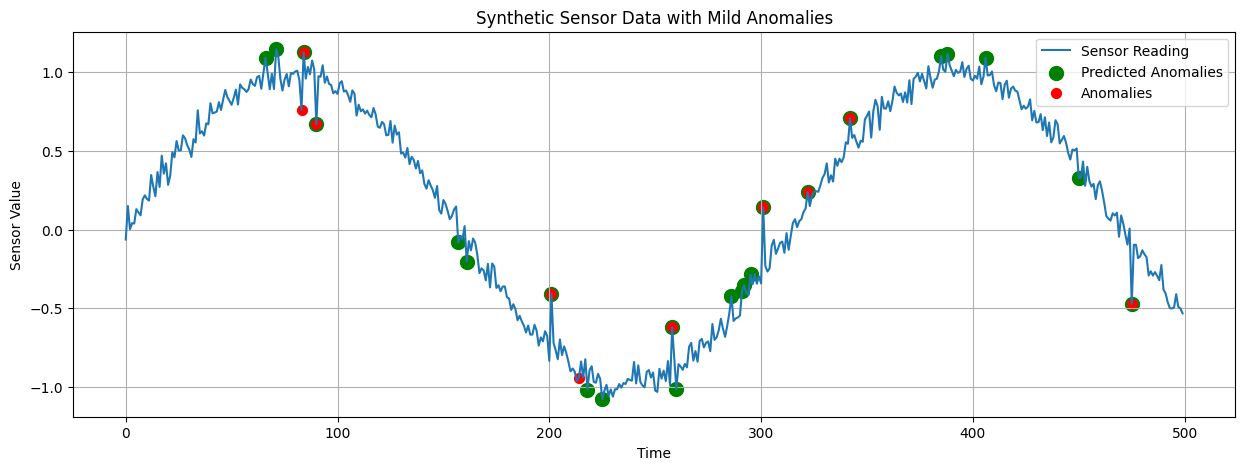

In [111]:
plt.figure(figsize=(15, 5))
plt.plot(data, label='Sensor Reading')
plt.scatter(predicted_indices, data[predicted_indices], color='green', label='Predicted Anomalies', s = 100)
plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label='Anomalies', s = 50)
plt.title("Synthetic Sensor Data with Mild Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

In [112]:
print(np.intersect1d(predicted_indices, df[df['anomaly'] == 1].index.to_numpy())) 

[ 84  90 201 258 301 322 342 475]


In [137]:
class ManualLSTM():
    def __init__(self, input_size, hidden_size):
        self.learning_rate = 0.01
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_xf = torch.randn( input_size, hidden_size, requires_grad=True, device = device)
        self.W_xi = torch.randn( input_size, hidden_size, requires_grad=True, device = device) 
        self.W_xg = torch.randn( input_size, hidden_size, requires_grad=True, device = device)
        self.W_xo = torch.randn( input_size, hidden_size, requires_grad=True, device = device)
        self.W_hf = torch.randn(hidden_size, hidden_size, requires_grad=True, device = device)
        self.W_hi = torch.randn(hidden_size, hidden_size, requires_grad=True, device = device)
        self.W_hg = torch.randn(hidden_size, hidden_size, requires_grad=True, device = device)
        self.W_ho = torch.randn(hidden_size, hidden_size, requires_grad=True, device = device)

        self.b_f = torch.randn(hidden_size, requires_grad=True, device = device)
        self.b_i = torch.randn(hidden_size, requires_grad=True, device = device)
        self.b_g = torch.randn(hidden_size, requires_grad=True, device = device)
        self.b_o = torch.randn(hidden_size, requires_grad=True, device = device)

        output_size = 1
        self.W_out = torch.randn(hidden_size, output_size, requires_grad=True, device = device)
        self.b_out = torch.randn(output_size, requires_grad=True, device = device)
    
    def forward(self, x_t_seq):
        
        h_t = torch.zeros(1, self.hidden_size, device= device)
        c_t = torch.zeros(1, self.hidden_size, device= device)
        
    
        for t in range(len(x_t_seq)):                 # Loop over time steps
            x_t = x_t_seq[t].unsqueeze(0)         # Shape: (1, input_size)
        
            f_t = torch.sigmoid(x_t @ self.W_xf + h_t @ self.W_hf + self.b_f)
            i_t = torch.sigmoid(x_t @ self.W_xi + h_t @ self.W_hi + self.b_i)
            g_t = torch.tanh(   x_t @ self.W_xg + h_t @ self.W_hg + self.b_g)
            o_t = torch.sigmoid(x_t @ self.W_xo + h_t @ self.W_ho + self.b_o)

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
        return h_t @ self.W_out + self.b_out
    
    def step(self):
        with torch.no_grad():
            for params in [self.W_xf, self.W_xi, self.W_xg, self.W_xo,
                            self.W_hf, self.W_hi, self.W_hg, self.W_ho,
                            self.b_f, self.b_i, self.b_g, self.b_o,
                            self.W_out, self.b_out]:
                
                params -= self.learning_rate * params.grad
                params.grad.zero_()
                
    def save(self, filename):
        torch.save(self.__dict__, filename)
    
    def load(self, filename):
        state = torch.load(filename, map_location = device)
        self.__dict__.update(state)
    
    
        

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = ManualLSTM(input_size = input_size, hidden_size = 5)
loss_fn = nn.MSELoss()
learning_rate = 0.001

In [139]:
loss_fn = nn.MSELoss()

learning_rate = 0.001
epochs = 50

for n in range(epochs):
    total_loss = 0.0
    for i in range(batch_size):                    # Loop over samples
        x_t_seq = X_tensor[i]                     # Shape: (seq_len, input_size)
        
        
        
        y_pred = model2.forward(x_t_seq)
        y_true = y_tensor[i].view(1,1)
    
        loss = loss_fn(y_pred, y_true)
    
        total_loss += loss
    
        loss.backward()
        
        model2.step()
            
    
    
    print(f"Epochs {n}: Total Loss = {total_loss:.6f}")

Epochs 0: Total Loss = 7.013564
Epochs 1: Total Loss = 3.012076
Epochs 2: Total Loss = 2.676898
Epochs 3: Total Loss = 2.392073
Epochs 4: Total Loss = 2.151564
Epochs 5: Total Loss = 1.949802
Epochs 6: Total Loss = 1.781626
Epochs 7: Total Loss = 1.642290
Epochs 8: Total Loss = 1.527466
Epochs 9: Total Loss = 1.433293
Epochs 10: Total Loss = 1.356330
Epochs 11: Total Loss = 1.293582
Epochs 12: Total Loss = 1.242481
Epochs 13: Total Loss = 1.200836
Epochs 14: Total Loss = 1.166829
Epochs 15: Total Loss = 1.138952
Epochs 16: Total Loss = 1.115973
Epochs 17: Total Loss = 1.096902
Epochs 18: Total Loss = 1.080938
Epochs 19: Total Loss = 1.067440
Epochs 20: Total Loss = 1.055904
Epochs 21: Total Loss = 1.045938
Epochs 22: Total Loss = 1.037223
Epochs 23: Total Loss = 1.029512
Epochs 24: Total Loss = 1.022611
Epochs 25: Total Loss = 1.016369
Epochs 26: Total Loss = 1.010663
Epochs 27: Total Loss = 1.005401
Epochs 28: Total Loss = 1.000506
Epochs 29: Total Loss = 0.995921
Epochs 30: Total Los

In [140]:
true_val2 = []
pred_val2 = []

for i in range(batch_size):
    y_pred = model2.forward(X_tensor[i])
    pred_val2.append(y_pred.item())
    y_true = y_tensor[i]
    true_val2.append(y_true.item())
        
true_val2 = np.array(true_val2)
pred_val2 = np.array(pred_val2)

In [141]:
abs_value2 = np.abs(pred_val2 - true_val2)
print()
percentile_952 = np.percentile(abs_value2, 95)
ind2 = np.where(abs_value2 > percentile_952)[0]
predicted_indices2 = ind2 + series_length
predicted_indices2

array([ 71,  84,  90,  91, 161, 201, 202, 218, 243, 257, 258, 259, 301,
       302, 342, 353, 357, 370, 372, 379, 388, 475, 476])

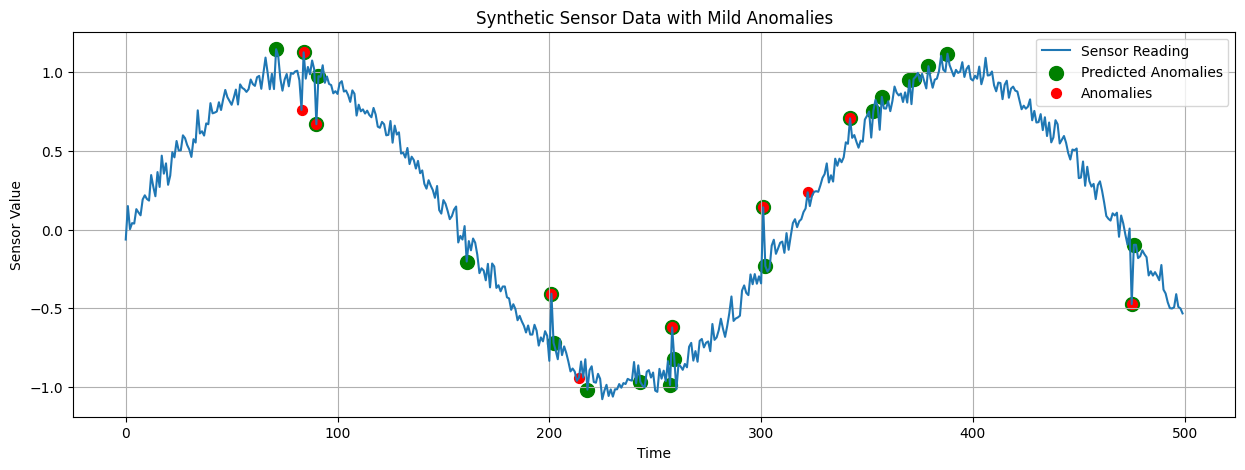

In [142]:
plt.figure(figsize=(15, 5))
plt.plot(data, label='Sensor Reading')
plt.scatter(predicted_indices2, data[predicted_indices2], color='green', label='Predicted Anomalies', s = 100)
plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label='Anomalies', s = 50)
plt.title("Synthetic Sensor Data with Mild Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

In [165]:
pred_anam_manual_lstm = np.intersect1d(predicted_indices2, df[df['anomaly'] == 1].index.to_numpy())
print(f"Manual-LSTM Anaomalies:\n Total Predicted: {len(predicted_indices2)}\n Correctly Predicted: {len(pred_anam_manual_lstm)}\n Correct Indexes: {pred_anam_manual_lstm}\n All Indexes: {predicted_indices2}\n")

pred_anam_manual = np.intersect1d(predicted_indices, df[df['anomaly'] == 1].index.to_numpy())
print(f"LSTM Anaomalies:\n Total Predicted: {len(predicted_indices)}\n Correctly Predicted: {len(pred_anam_manual)}\n Correct Indexes: {pred_anam_manual}\n All Indexes: {predicted_indices}\n")


print(f"Predictions in common in both LSTM:{np.intersect1d(predicted_indices2, predicted_indices)}, Total: {len(np.intersect1d(predicted_indices2, predicted_indices))}")



Manual-LSTM Anaomalies:
 Total Predicted: 23
 Correctly Predicted: 7
 Correct Indexes: [ 84  90 201 258 301 342 475]
 All Indexes: [ 71  84  90  91 161 201 202 218 243 257 258 259 301 302 342 353 357 370
 372 379 388 475 476]

LSTM Anaomalies:
 Total Predicted: 23
 Correctly Predicted: 8
 Correct Indexes: [ 84  90 201 258 301 322 342 475]
 All Indexes: [ 66  71  84  90 157 161 201 218 225 258 260 286 291 292 295 301 322 342
 385 388 406 450 475]

Predictions in common in both LSTM:[ 71  84  90 161 201 218 258 301 342 388 475], Total: 11


Correct Predicted LSTM Anaomalies: [ 84  90 201 258 301 322 342 475], total: 8


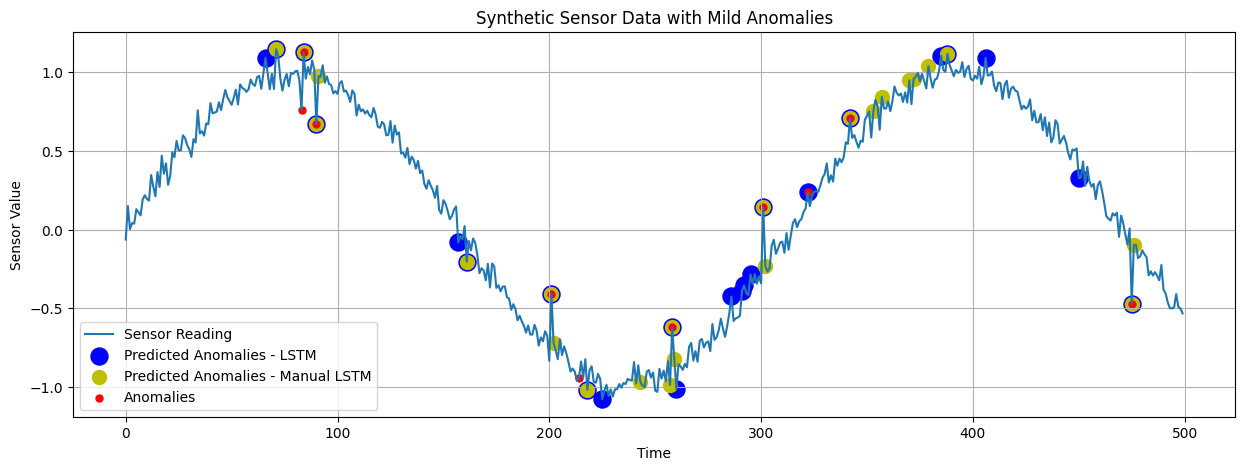

In [168]:
plt.figure(figsize=(15, 5))
plt.plot(data, label='Sensor Reading')
plt.scatter(predicted_indices, data[predicted_indices], color='blue', label='Predicted Anomalies - LSTM', s = 150)
plt.scatter(predicted_indices2, data[predicted_indices2], color='y', label='Predicted Anomalies - Manual LSTM', s = 100)
plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label='Anomalies', s = 25)
plt.title("Synthetic Sensor Data with Mild Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()